# Reading and Loading Dat Using Spark and Postgres

Below is the code to find spark and import the spark libraries to use.  And other essential libraries. 

In [1]:
import findspark
findspark.init('/home/emanalytics/spark-3.3.1-bin-hadoop3')

import pyspark

from pyspark.sql import SparkSession
from pyspark.sql import Row
from lib.DataFlow import *

The next cell i am using a yaml file that contain the postgres credetial.   Therefore I used a lib.Dataflow where I created the read_file to read from a yaml and pull the crendentials.  The save from hardcoding the values.  

In [2]:
ymlData = read_file('config/config.yaml')

host = ymlData['postgres']['host']
port = ymlData['postgres']['port']
db = ymlData['postgres']['database']
user = ymlData['postgres']['username']
password = ymlData['postgres']['password']


To load data from postgres I am using the jdbc format.  first we create a spark session specified where the postgres driver is located in this case is the .jar file and create the spark session.

use the spark session to read.format("jdbc") and configure the options with the postgres connections the .load() will load the data from postgres into the dataframe.

In [13]:

spark = SparkSession.builder.config("spark.jars", "/home/emanalytics/Downloads/postgresql-42.5.1.jar") \
    .master("local").appName("PySpark_Postgres_test1").getOrCreate()
    

jdbcDF = spark.read.format("jdbc"). \
options(
         url=f'jdbc:postgresql://{host}:{port}/{db}', # jdbc:postgresql://<host>:<port>/<database>
         dbtable='buppy',
         user=user,
         password=password,
         driver='org.postgresql.Driver').load()

22/12/15 17:27:33 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


In [14]:
jdbcDF.show()

+---+-----+
| id| name|
+---+-----+
|  1|Buppy|
+---+-----+



Below I created a spark dataframe where I will use to load that data frame into postgres. 

In [16]:
studentDf = spark.createDataFrame([
	Row(id=1,name='vijay',marks=67),
	Row(id=2,name='Ajay',marks=88),
	Row(id=3,name='jay',marks=79),
	Row(id=4,name='vinay',marks=67),
])

In [17]:
studentDf.show()

+---+-----+-----+
| id| name|marks|
+---+-----+-----+
|  1|vijay|   67|
|  2| Ajay|   88|
|  3|  jay|   79|
|  4|vinay|   67|
+---+-----+-----+



below is how we load the data into postgres similarly to the loading data into spark we use the write.format("jdbc") with the options parameters from the yaml file we then use the .save() method this will load the data and creates a table in postgres sql.  

In [20]:
studentDf.select('id', 'name', 'marks').write.format("jdbc"). \
options(
         url=f'jdbc:postgresql://{host}:{port}/{db}', # jdbc:postgresql://<host>:<port>/<database>
         dbtable='students',
         user=user,
         password=password,
         driver='org.postgresql.Driver').save()

In [3]:
spark = SparkSession.builder.config("spark.jars", "/home/emanalytics/Downloads/postgresql-42.5.1.jar") \
    .master("local").appName("Electric Cars").getOrCreate()

22/12/15 20:07:24 WARN Utils: Your hostname, emanalytics-VirtualBox resolves to a loopback address: 127.0.1.1; using 10.0.2.15 instead (on interface enp0s3)
22/12/15 20:07:24 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
22/12/15 20:07:27 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


In [15]:
df = spark.read.csv('data/Electric_Vehicle_Population_Data.csv', inferSchema=True, header=True)
df.printSchema()
df.show()

root
 |-- VIN (1-10): string (nullable = true)
 |-- County: string (nullable = true)
 |-- City: string (nullable = true)
 |-- State: string (nullable = true)
 |-- Postal Code: integer (nullable = true)
 |-- Model Year: integer (nullable = true)
 |-- Make: string (nullable = true)
 |-- Model: string (nullable = true)
 |-- Electric Vehicle Type: string (nullable = true)
 |-- Clean Alternative Fuel Vehicle (CAFV) Eligibility: string (nullable = true)
 |-- Electric Range: integer (nullable = true)
 |-- Base MSRP: integer (nullable = true)
 |-- Legislative District: integer (nullable = true)
 |-- DOL Vehicle ID: integer (nullable = true)
 |-- Vehicle Location: string (nullable = true)
 |-- Electric Utility: string (nullable = true)
 |-- 2020 Census Tract: long (nullable = true)

+----------+---------+-----------------+-----+-----------+----------+---------+----------+---------------------+-------------------------------------------------+--------------+---------+--------------------+-------

In [16]:
df.count()

112634

In [19]:
df2 = df.select('county', 'city', 'state', 'postal code').dropDuplicates()
df2.count()

978

In [20]:
plotDF = df.groupBy('Make').count()
plotDF.show()

+------------+-----+
|        Make|count|
+------------+-----+
|     PORSCHE|  818|
|LUCID MOTORS|   65|
|     HYUNDAI| 1412|
|        FIAT|  822|
|      TOYOTA| 4405|
|      SUBARU|   59|
|      NISSAN|12880|
|     BENTLEY|    3|
|        FORD| 5819|
|        AUDI| 2332|
|        MINI|  632|
|   CHEVROLET|10182|
|      JAGUAR|  219|
|       LEXUS|   33|
|        JEEP| 1152|
|       VOLVO| 2288|
|       TESLA|52078|
|    POLESTAR|  558|
|         BMW| 4680|
|  VOLKSWAGEN| 2514|
+------------+-----+
only showing top 20 rows



In [21]:
import matplotlib.pyplot as plt 

import pandas 

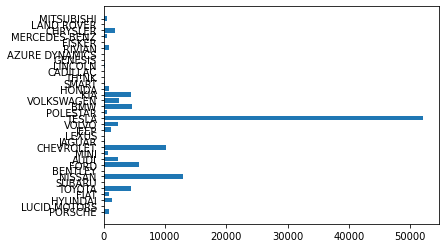

In [23]:
x = plotDF.toPandas()['Make'].values.tolist()
y = plotDF.toPandas()['count'].values.tolist() 

plt.barh(x,y)
plt.show()